In [1]:
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors


import sys
sys.path.append('../../..')
from batchflow.opensets import Imagenette160
from batchflow import Pipeline, B, V, C, W

from batchflow.models.torch import ResNet34, ResBlock, SelfAttention
from batchflow.models.torch.layers import ConvBlock

from batchflow.models.metrics import ClassificationMetrics
from batchflow.research import Research, Option, Results, KV, RP, REU, RI
from batchflow.utils import plot_results_by_config, show_research, print_results

In [2]:
# Global constants
NUM_ITERS = 50000                               # number of iterations to train each model for
N_REPS = 4                                      # number of times to repeat each model train
RESEARCH_NAME = 'research'                      # name of Research object
DEVICES = [4, 5, 6, 7]                          # devices to use
WORKERS = len(DEVICES)                          # number of simultaneously trained models
TEST_FREQUENCY = 50

dataset = Imagenette160()                       # dataset to train models on

In [3]:
class SAResBlock(nn.Module):
    def __init__(self, inputs=None, **kwargs):
        super(SAResBlock, self).__init__()

        self.layer = ConvBlock({'base': ResBlock, **kwargs},
                               {'base': SelfAttention},
                               inputs=inputs)
        
    def forward(self, x):
        return self.layer(x)

In [4]:
domain = (Option('body', [KV({'encoder/blocks/base':ResBlock, 'encoder/blocks/se': False},
                             'ResBlock'),
                          KV({'encoder/blocks/base':ResBlock, 'encoder/blocks/se': True},
                             'SEResBlock'),
                          KV({'encoder/blocks/base':SAResBlock},
                             'SAResBlock'), 
                          KV({'encoder/blocks/base':SAResBlock, 'encoder/blocks/se': True},
                             'SESAResBlock'),
                         ]))

In [5]:
config = {
    'inputs/labels/classes': 10,
    'body': C('body'),
    'head/layout': 'Vf',
    'head/units': 10,
    'device': C('device'),
}

In [6]:
train_root = (dataset.train.p      
                  .crop(shape=(160, 160), origin='center')
                  .to_array(channels='first', dtype=np.float32)
                  .run_later(64, n_epochs=None, drop_last=True,
                             shuffle=True, prefetch=3)
                   )

train_pipeline = (Pipeline()
                  .init_variable('loss')
                  .init_model('dynamic', ResNet34, 'my_model', config=config) 
                  .train_model('my_model', B('images'), B('labels'), 
                               fetches='loss', save_to=V('loss'))
                 )


In [7]:
def acc(iteration, import_from):
    pipeline = (dataset.test.p
                 .import_model('my_model', import_from)
                 .init_variable('true', [])
                 .update(V('true', mode='a'), B.labels) 
                 .init_variable('predictions', [])
                 .crop(shape=(160, 160), origin='center')
                 .to_array(channels='first', dtype=np.float32)
                 .predict_model('my_model', B('images'), fetches='predictions',
                                save_to=V('predictions', mode='a')))
                 
    pipeline.run(128, n_epochs=1, drop_last=False, shuffle=True)
    pred = np.concatenate(pipeline.v('predictions'))
    true = np.concatenate(pipeline.v('true'))
    accuracy = ClassificationMetrics(true, pred, fmt='logits',
                                     num_classes=10, axis=1).accuracy()
    return accuracy

In [8]:
research = (Research()
            .init_domain(domain, n_reps=N_REPS)
            .add_pipeline(root=train_root, branch=train_pipeline, variables='loss',
                          name='train_ppl', logging=True)
            .add_callable(acc, returns='acc_vall', name='acc_fn', execute=TEST_FREQUENCY,
                          iteration=RI(), import_from=RP('train_ppl')))

In [ ]:
!rm -rf research

research.run(NUM_ITERS, name=RESEARCH_NAME,
             devices=DEVICES, workers=WORKERS,
             bar=True)

Research research is starting...


Domain updated: 0:  37%|███▋      | 292835/800000.0 [6:06:56<10:35:31, 13.30it/s]

In [15]:
%%time
results = Results(path=RESEARCH_NAME, concat_config=True)
# results = research.load_results(concat_config=True)

CPU times: user 13min 49s, sys: 0 ns, total: 13min 49s
Wall time: 13min 49s


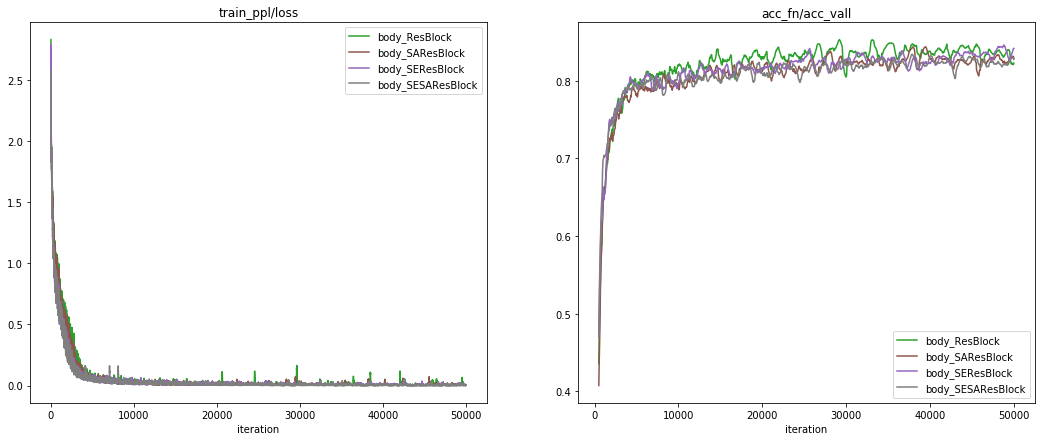

In [16]:
show_research(results.df, layout=['train_ppl/loss', 'acc_fn/acc_vall'], average_repetitions=True, 
              color=list(mcolors.TABLEAU_COLORS.keys()), log_scale=False, rolling_window=10)

In [17]:
print_results(results.df, 'acc_fn/acc_vall', False, ascending=True, n_last=100)

,acc_fn_2,acc_fn_3,acc_fn_0,acc_fn_1,acc_fn_mean,acc_fn_std
body_ResBlock,0.849076,0.847023,0.830595,0.845996,0.843172,0.007346
body_SAResBlock,0.841889,0.817248,0.815195,0.829569,0.825975,0.010707
body_SEResBlock,0.848049,0.856263,0.844969,0.826489,0.843943,0.010890
body_SESAResBlock,0.833676,0.830595,0.829569,0.814168,0.827002,0.007562
